In [29]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import signal, ndimage, interpolate, stats
from scipy.interpolate import CubicSpline

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
font = {'family' : 'sans-serif',
        'size'   : 20}

plt.rc('font', **font)

import statsmodels.api as sm
from sklearn.model_selection import train_test_split

from pathlib import Path
import os,sys,time,h5py

import nept
sys.path.append('../PreProcessing/')  
sys.path.append('../TrackingAnalyses/')
sys.path.append('../Analyses/')
sys.path.append('../Lib/')

import pre_process_neuralynx as PPN
import TreeMazeFunctions as TMF
from importlib import reload  # Python 3.4+ only.
from filters_ag import *
import spike_functions as SF
import json
#PPN=reload(PPN)
#TMF=reload(TMF)


In [35]:
# OAKPaths
oakPaths = {}
oakPaths['Root'] = Path('/mnt/o/giocomo/alexg/')
oakPaths['Clustered'] = Path('/mnt/o/giocomo/alexg/Clustered/')
oakPaths['PreProcessed'] = Path('/mnt/o/giocomo/alexg/PreProcessed/')
oakPaths['Raw'] = Path('/mnt/o/giocomo/alexg/RawData/InVivo/')
oakPaths['Analyses'] = Path('/mnt/o/giocomo/alexg/Analyses')


In [38]:
def getSessionPaths(rootPath, session):
    tmp = session.split('_')
    animal = tmp[0]
    task = tmp[1]
    date = tmp[2]
    
    Paths = {}
    Paths['Clusters'] = rootPath['Clustered'] / animal /(session+'_KSClusters')    
    Paths['Raw'] = rootPath['Raw'] / animal / session
    Paths['PreProcessed'] = rootPath['PreProcessed'] / animal / (session + '_Results')
    Paths['Analyses'] = rootPath['Analyses'] / animal/ (session + '_Analyses')
    Paths['Analyses'].mkdir(parents=True, exist_ok=True)
    Paths['ClusterTable'] = rootPath['Clustered'] / animal / (animal+'_ClusteringSummary.json') 
    return Paths

In [39]:
animal = 'Li'
task = 'T3g'
date = '062718'
session = animal+'_'+task+'_'+date
sessionPaths = getSessionPaths(oakPaths,session)


In [40]:
oakPaths

{'Root': PosixPath('/mnt/o/giocomo/alexg'),
 'Clustered': PosixPath('/mnt/o/giocomo/alexg/Clustered'),
 'PreProcessed': PosixPath('/mnt/o/giocomo/alexg/PreProcessed'),
 'Raw': PosixPath('/mnt/o/giocomo/alexg/RawData/InVivo'),
 'Analyses': PosixPath('/mnt/o/giocomo/alexg/Analyses')}

In [17]:
posPath = Path(sessionPaths['Raw'],'VT1.nvt')
t,x,y,ha = PPN.load_nvt2(posPath)
step = 0.02
PosDat = TMF.getPositionMat(x,y,t,step)

Smoothing track data completed: 23.43 s 
Resampling the Data to 0.02 seconds completed: 0.03 s 
Converting Track x,y to TreeMaze Positions Completed: 10.43 s
Creating Position Matrix Completed : 10.46 s
Creating Segment Direction Matrix Complete: 9.35 s
Processing of Position Data Complete : 43.27 s


In [44]:
fn = sessionPaths['Analyses'] / ('PositionVariables_{}ms.npz'.format(int(step*1000)))
np.savez(fn,x=PosDat['x'],y=PosDat['y'],t=PosDat['t'],PosZones=PosDat['PosZones'],SegDir=PosDat['SegDirMat'])

In [45]:
PosDat2=np.load(fn)

In [48]:
PosDat2

(-160, 1500)

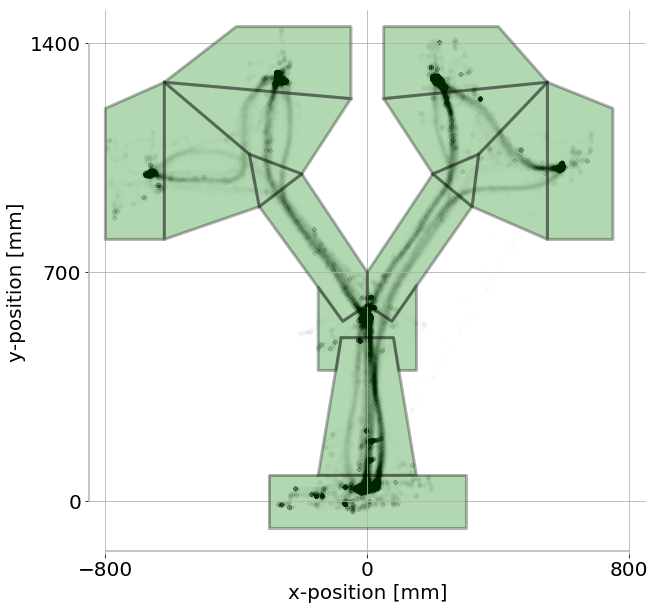

In [28]:
f,a1=plt.subplots(1,1, figsize=(10,10))

for zo in TMF.MazeZonesGeom.keys():
    TMF.plotPoly(TMF.MazeZonesGeom[zo],a1)
    
for spine in plt.gca().spines.values():
    spine.set_visible(False)
#a1.plot(PosDat['x'],PosDat['y'],alpha=0.1,color='k',linewidth=0.1)
a1.scatter(PosDat['x'],PosDat['y'],20, alpha=0.005,color='k')
a1.set_xlabel('x-position [mm]')
a1.set_ylabel('y-position [mm]')
a1.axis('equal')
a1.grid()
a1.hlines(-150,-800,800,color=(0.7,0.7,0.7))
a1.vlines(-850,0,1400,color=(0.7,0.7,0.7))
a1.set_xlim([-800,800])
a1.set_xticks([-800,0,800])
a1.set_yticks([0,700,1400])
a1.set_ylim([-160,1500])
#f.savefig('/Users/alexgonzalez/Google Drive/PostDoc/FloorMeeting/TreeMazeCoverage.png',dpi=500)


In [8]:
def plotCounts(counts, names,ax):
    nX = len(names)
    ab=sns.barplot(x=np.arange(nX),y=counts,ax=ax, ci=[],facecolor=(0.4, 0.6, 0.7, 1))
    #ax.set_yscale('log')
    
    ax.set_xticks(np.arange(nX))
    ax.set_xticklabels(names)
    #ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())

    sns.set_style("whitegrid")
    sns.despine(left=True)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    return ax

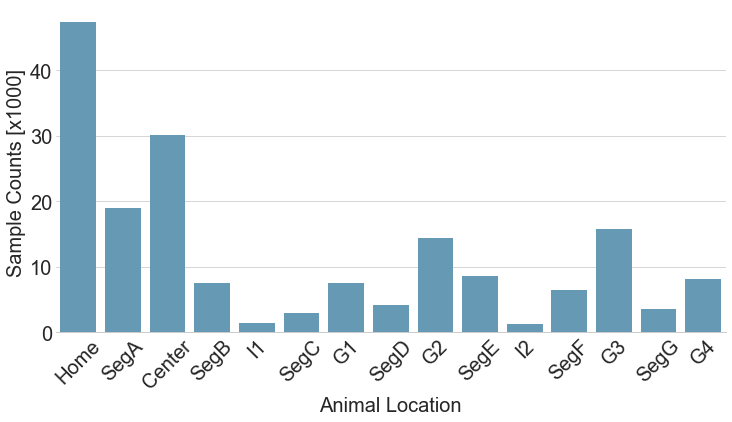

In [10]:
f,a1=plt.subplots(1,1, figsize=(12,6))
counts = np.sum(PosDat['PosMat'])
a1 = plotCounts(counts/1000,TMF.ZonesNames,a1)
a1.set_xlabel('Animal Location')
a1.set_ylabel('Sample Counts [x1000] ')
f.savefig('/Users/alexgonzalez/Google Drive/PostDoc/FloorMeeting/LocSampleCounts.pdf',dpi=500,
          bbox_inches='tight',pad_inches=0.2)

In [11]:
# path to event data
evPath = Path(rootDatPath,fn,'Events.nev')
ev = PPN.get_events(evPath)
_,EventMat = TMF.getEventMatrix(ev,PosDat['t'])

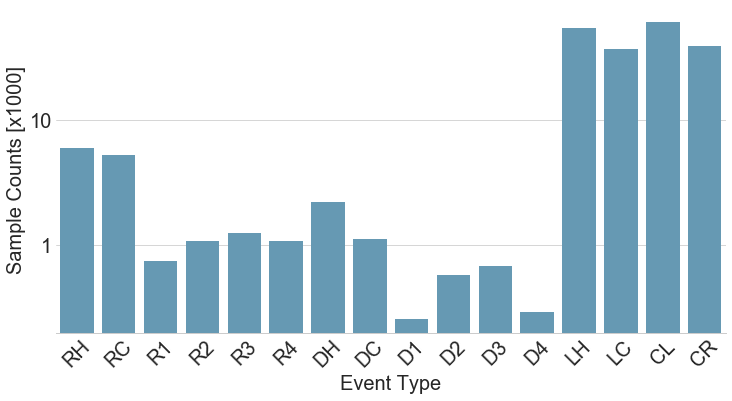

In [12]:
f,a1=plt.subplots(1,1, figsize=(12,6))
ev_subset = ['RH','RC','R1','R2','R3','R4','DH','DC','D1','D2','D3','D4',
             'LH','LC','CL','CR']
counts = np.sum(EventMat[ev_subset]/1000,0)

a1 = plotCounts(counts,ev_subset,a1)
a1.set_yscale('log')
a1.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
a1.set_yticks([1,10])
a1.set_yticklabels([1,10])
a1.set_xlabel('Event Type')
a1.set_ylabel('Sample Counts [x1000]')

f.savefig('/Users/alexgonzalez/Google Drive/PostDoc/FloorMeeting/EventSubsetCounts.pdf',dpi=500,
          bbox_inches='tight',pad_inches=0.2)


In [13]:
def plotBehWindow(time,dat,names,ax):
    sns.heatmap(dat,ax=ax,yticklabels=names,cbar=0,cmap='Greys_r',vmax=1.1)
    ax.hlines(np.arange(len(names)+1), *ax.get_xlim(),color=(0.7,0.7,0.7,1))
    x=ax.get_xticks().astype(int)
    x=np.linspace(x[0],x[-1], 6, endpoint=False).astype(int) 
    x=x[1::]
    ax.set_xticks(x)
    ax.vlines(x,*ax.get_ylim(),color=(0.3,0.3,0.3,1),linestyle='-.')
    _=ax.set_xticklabels(np.round(time[x]).astype(int))
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    return ax

In [157]:
minMark=43*60+t[0]
window=np.where(np.logical_and(t>=minMark,t<(minMark+60)))[0]

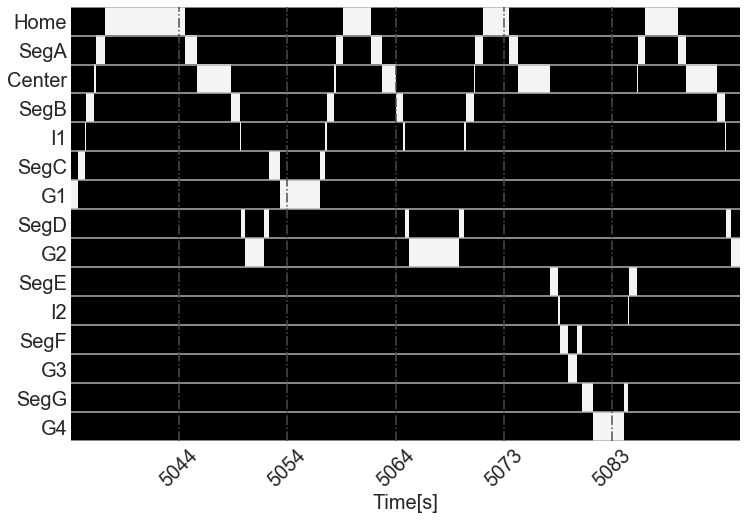

In [158]:
f,(a1)=plt.subplots(1,1, figsize=(12,8))
t = PosDat['t']
a1=plotBehWindow(t[window],PosDat['PosMat'].iloc[window].T,TMF.ZonesNames,a1)
a1.set_xlabel('Time[s]')
f.savefig('/Users/alexgonzalez/Google Drive/PostDoc/FloorMeeting/LocWindow.png',dpi=500,
          bbox_inches='tight',pad_inches=0.2)

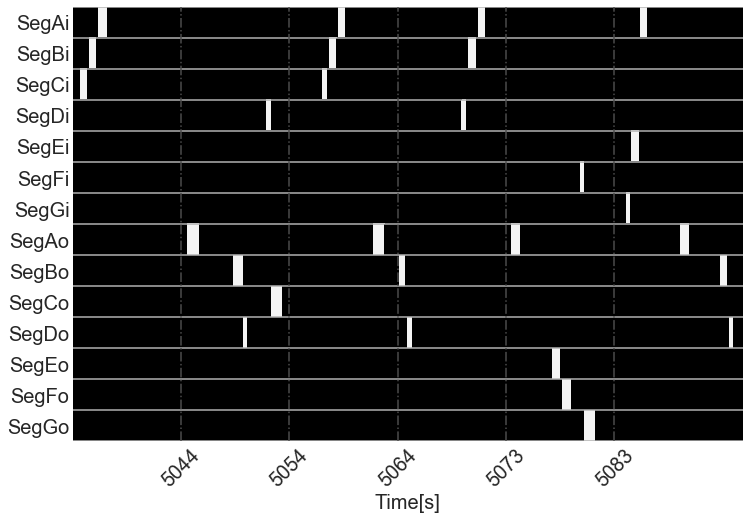

In [159]:
f,(a1)=plt.subplots(1,1, figsize=(12,8))
t = PosDat['t']
a1=plotBehWindow(t[window],PosDat['SegDirMat'].iloc[window].T,TMF.SegDirNames,a1)
a1.set_xlabel('Time[s]')
f.savefig('/Users/alexgonzalez/Google Drive/PostDoc/FloorMeeting/LocDirWindow.png',dpi=500,
          bbox_inches='tight',pad_inches=0.2)

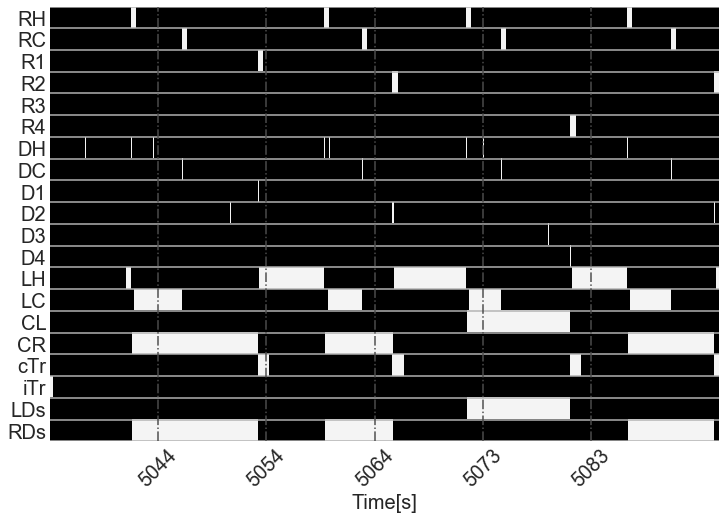

In [160]:
f,(a1)=plt.subplots(1,1, figsize=(12,8))
t = PosDat['t']
ev_subset=['RH','RC','R1','R2','R3','R4','DH','DC','D1','D2','D3','D4',
             'LH','LC','CL','CR','cTr','iTr','LDs','RDs']
mat = EventMat[ev_subset].iloc[window].T
a1=plotBehWindow(t[window],mat,ev_subset,a1)
a1.set_xlabel('Time[s]')
f.savefig('/Users/alexgonzalez/Google Drive/PostDoc/FloorMeeting/EvWindow.png',dpi=500,
          bbox_inches='tight',pad_inches=0.2)

In [596]:
SR = 32000
nTimePoints = len(t)

filename = animal+'_'+task+'_'+date+'_Results'
datPath=Path('/Users/alexgonzalez/Google Drive/PostDoc/Data/',task,animal,filename)

os.chdir(str(datPath))
spike_times = {}
bin_spikes = np.zeros((15,nTimePoints))

# selected_cells = {}
# selected_cells['2']=['5','6']
# selected_cells['3']=['0','1','3','5','6','8','10','11','12','15']
# selected_cells['7']=['0','3','4']
# selected_cells['8']=['1','2','3','5','6','12']
# selected_cells['10']=['0','3','4','7','9','11','14','18','20','22','23','25']
# selected_cells['14']=['0','4','21','22','9','11','14','18','20','22','23','25']
# selected_cells['15']=['16']


#these cells are for 062718
selected_cells = {}
selected_cells['2'] = ['2','3']
selected_cells['3'] = ['1','5','13','15','21','25']
selected_cells['6'] = ['5']
selected_cells['8'] = ['0','1','2','4','5','7']

cnt=0
for tt in selected_cells.keys():
    try:
        params    = CircusParser(str(datPath)+'/tt_'+tt+'.npy')
        results = load_data(params, 'results') # To load the templates
        #time = np.arange(97)/32
        templates = selected_cells[tt]
        for ti in templates:
            cl[cnt]=np.copy(results['spiketimes']['temp_'+ti]) 
            sp_per_bin, _=np.histogram(cl[cnt],bins=nTimePoints)
            bin_spikes[cnt,:]=sp_per_bin
            cnt+=1
    except:
        print('Could not load template for tetrode {}'.format(tt))
        print ("error", sys.exc_info()[0],sys.exc_info()[1],sys.exc_info()[2].tb_lineno)

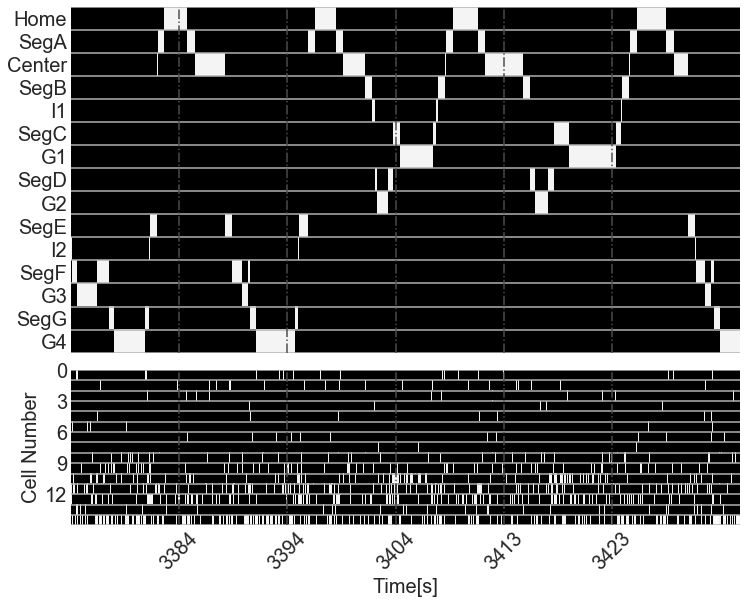

In [678]:
window = np.arange(3000)+2000*23
f,(a1,a2)=plt.subplots(2,1, figsize=(12,12))
t = PosDat['t']
a1.set_position([0.125, 0.4, 0.775, 0.4])
#a1=plotBehWindow(t[window],PosDat['SegDirMat'].iloc[window].T,TMF.SegDirNames,a1)
a1=plotBehWindow(t[window],PosDat['PosMat'].iloc[window].T,TMF.ZonesNames,a1)
a1.set_xticks([])

nCells = bin_spikes.shape[0]
a2=plotBehWindow(t[window],bin_spikes[:,window],np.arange(nCells).astype(str),a2)
a2.set_xlabel('Time[s]')
a2.set_ylabel('Cell Number')
# f.savefig('/Users/alexgonzalez/Google Drive/PostDoc/FloorMeeting/LocWindow.png',dpi=500,
#           bbox_inches='tight',pad_inches=0.2)
a2.set_position([0.125, 0.2, 0.775, 0.18])
yt=np.linspace(0,nCells,5, endpoint=False).astype(int)
a2.set_yticks(yt)
a2.set_yticklabels(yt.astype(str))
for tick in a2.get_yticklabels():
    tick.set_rotation(0)

f.savefig('/Users/alexgonzalez/Google Drive/PostDoc/FloorMeeting/LocSpikesWindow.png',dpi=500,
          bbox_inches='tight',pad_inches=0.2)    

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:               178630
Model:                            GLM   Df Residuals:                   178601
Model Family:                 Poisson   Df Model:                           28
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -67176.
Date:                Thu, 14 Mar 2019   Deviance:                       91579.
Time:                        09:47:05   Pearson chi2:                 1.90e+05
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7858      0.047    -38.027      0.000      -1.878      -1.694
SegAi         -0.5557      0.057     -9.730      0.0

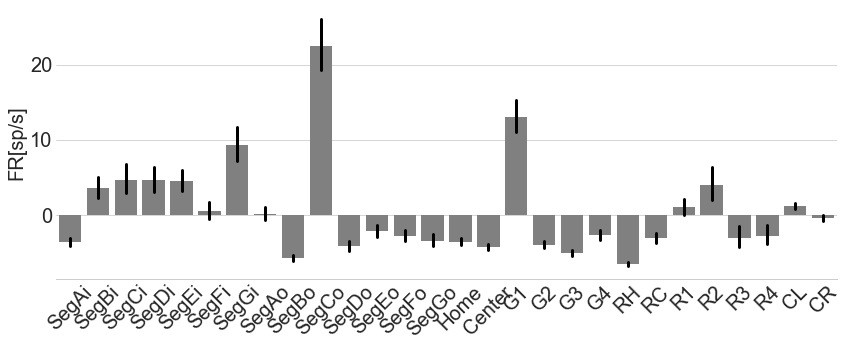

In [680]:
#selected_params = ['Home','SegA','Center','SegB','I1','SegC','G1','SegD',
#                   'G2','SegE','I2','SegF','G3','SegG','G4','RH','RC','R1','R2','R3','R4','CL','CR']
selected_params = ['SegA','Center','SegB','I1','SegC','G1','SegD',
                   'G2','SegE','I2','SegF','G3','SegG','G4','RH','RC','R1','R2','R3','R4','CL','CR']

reward_params = ['RH','RC','R1','R2','R3','R4']
cue_params = ['CL','CR']
dir_params = TMF.SegDirNames
goal_params = ['Home','Center','G1','G2','G3','G4']

#gr_mat = pd.DataFrame(np.zeros(nTimePoints,4),columns=['GR1','GR2','GR3','GR4'])
#gr_mat = np.logical_and(FullMat['G4'],FullMat['R4'])
FullMat=pd.concat([PosDat['PosMat'],PosDat['SegDirMat'],EventMat],axis=1)

selected_params =dir_params+goal_params+reward_params+cue_params
M2 = sm.add_constant(FullMat[selected_params])
#M2=FullMat[selected_params]



# rate = 0.05
# sb = np.random.poisson(rate,len(t)) # spikes per bin
# sb[M2['SegAi']==1] = np.random.poisson(rate*6,np.sum(M2['SegAi']==1))
# sb[M2['G1']==1] = np.random.poisson(rate*2,np.sum(M2['G1']==1))

y=bin_spikes[10,:]
#y=sb

xTrain, xTest, yTrain, yTest = train_test_split(M2,y, test_size = 0.5, random_state = 0,shuffle=False)


glm_p = sm.GLM(y,xTrain,family = sm.families.Poisson())

res=glm_p.fit()
print('Training Data Fit')
print(res.summary())
plot_eFR(res,step,selected_params)
print('Pseduo R squared Full:', (1-res.deviance/res.null_deviance))


In [366]:
(np.exp(res.params['SegAo']-res.params['SegAi'])-1)*np.mean(np.exp(res.params[0]))/step

6.556748182097692

In [699]:
np.mean(y[M2['SegCo']==1])/step,np.mean(y[M2['SegCi']==1])/step


(31.29640205596802, 13.114071606994171)

In [696]:
np.mean(y[np.logical_and(M2['G1']==1,M2['R1']==1)]/step)

24.65564738292011

In [697]:
np.mean(y[np.logical_and(M2['G1']==1,M2['R1']==0)]/step)

21.415981198589893

In [17]:
def plot_eFR(res,step,selected_params):
    estimatedBaseRate = np.exp(res.params[0])/step
    ci=(np.exp(res.conf_int()[1::])-1)*estimatedBaseRate
    estimatedFRs = (np.exp(res.params[1::])-1)*estimatedBaseRate
    nParams=len(res.params)-1
    x=np.tile(np.arange(nParams),[2,1])
    #sns.barplot(x=np.arange(57),y=np.exp(res.params)-1,ci=np.exp(res.conf_int()-1),capsize=.2)
    
    f,a=plt.subplots(1,1, figsize=(14,5))
    ab=sns.barplot(x=np.arange(nParams),y=estimatedFRs,ax=a, 
                   facecolor=(0.5, 0.5, 0.5, 1))
    for p in np.arange(nParams):
        a.plot(x[:,p],ci.iloc[p],color='k',linewidth=3)
    a.set_ylabel('FR[sp/s]')
    a.set_xticklabels(selected_params)
    #a.grid()
    sns.set_style("whitegrid")
    sns.despine(left=True)
    for tick in a.get_xticklabels():
        tick.set_rotation(45)
    return f,a
        

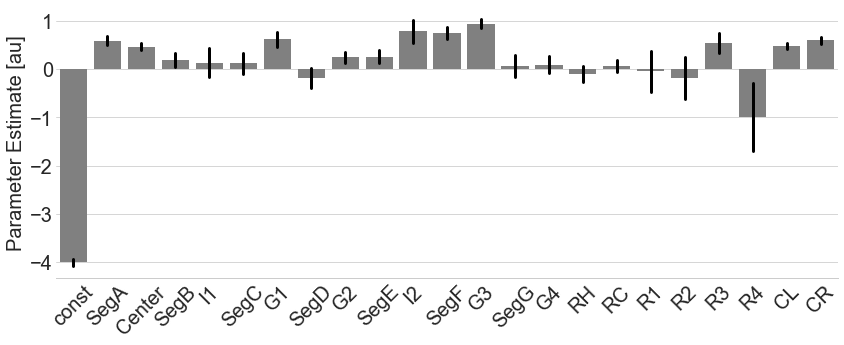

In [251]:
ci= res.conf_int()
estimatedFRs = res.params
nParams=len(res.params)
x=np.tile(np.arange(nParams),[2,1])
#sns.barplot(x=np.arange(57),y=np.exp(res.params)-1,ci=np.exp(res.conf_int()-1),capsize=.2)
f,a=plt.subplots(1,1, figsize=(14,5))
ab=sns.barplot(x=np.arange(nParams),y=estimatedFRs,ax=a, 
               facecolor=(0.5, 0.5, 0.5, 1))
for p in np.arange(nParams):
    a.plot(x[:,p],ci.iloc[p],color='k',linewidth=3)
a.set_ylabel('Parameter Estimate [au]')
a.set_xticklabels(['const']+selected_params)
#a.grid()
sns.set_style("whitegrid")
sns.despine(left=True)
for tick in a.get_xticklabels():
    tick.set_rotation(45)

In [243]:
OccProb=np.zeros(TMF.nZones)
FR_Occ=np.zeros(TMF.nZones)
for i in np.arange(TMF.nZones):
    ids = PosDat['PosZones']==i
    OccProb[i] = np.mean(ids)
    FR_Occ[i] = np.mean(y[ids])
OccProb,FR_Occ    

(array([0.26533057, 0.10592286, 0.16887981, 0.04240609, 0.00848682,
        0.01652578, 0.04217657, 0.02337233, 0.08081509, 0.04784191,
        0.00718804, 0.03666797, 0.08839501, 0.02009181, 0.04589935]),
 array([0.23656005, 0.26721632, 0.18404217, 0.25887789, 0.26583113,
        0.35230352, 0.24210247, 0.32742515, 0.16334165, 0.41575006,
        0.44548287, 0.28381679, 0.16314123, 0.40429089, 0.1852665 ]))

In [182]:
FR_Occ/OccProb

array([0.07522499, 0.29139297, 0.15290709, 0.62884048, 3.26441441,
       1.82436486, 0.67032091, 0.87108466, 0.21771802, 0.57721901,
       4.11725672, 0.72447107, 0.22066876, 1.10942377, 0.38264418])

In [232]:
def spatial_information(occupancy_prob, fr_map):
    meanFR = np.nanmean(fr_map)
    InfoMat = fr_map*occupancy_prob*np.log2(fr_map/meanFR)
    return 1/meanFR*np.nansum(InfoMat)
spatial_information(OccProb, FR_Occ)

-0.15763105997325894

In [245]:
FR_Occ/step

array([11.82800236, 13.36081602,  9.20210826, 12.94389439, 13.29155673,
       17.61517615, 12.10512344, 16.37125749,  8.16708229, 20.78750293,
       22.2741433 , 14.19083969,  8.15706143, 20.21454444,  9.2633248 ])

In [766]:
def PDeviance(y,mu):
    y = y+1e-10
    mu = mu+1e-10
    return 2*np.sum(y*np.log(y/mu)-(y-mu))

### trying tetrode 10 with KS output.

In [20]:
animal = 'Li'
task = 'T3g'
date = '062718'
fn = animal+'_'+task+'_'+date+'_KSClusters'
orig_time =np.arange(t[0],t[-1]+1,1/32000)

good_tts = [3,8,10]
datPath = Path('/Volumes/groups/giocomo/alexg/Clustered/',animal,fn)

nTotalCells=0
cell_sp = []
cell_ids = {}
nTimePoints=len(t)
for tt in good_tts:
    ttPath = Path(datPath,'tt_'+str(tt))
    spikes = np.load(str(ttPath/'spike_times.npy'))
    clusters = np.load(str(ttPath/'spike_clusters.npy'))
    cl_rating = pd.read_csv(str(ttPath/'cluster_group.tsv'),sep='\t')
    good_cl_ids = np.where(cl_rating['group']=='good')[0]
    nGoodCells = len(good_cl_ids)
    bin_spikes = np.zeros((nGoodCells,nTimePoints))
    cnt=0
    for cl in good_cl_ids:
        cell_ids[cnt] = [tt,cl]
        sp_per_bin, _=np.histogram(orig_time[spikes[clusters==cl]],bins=nTimePoints)    
        bin_spikes[cnt,:],_=np.histogram(orig_time[spikes[clusters==cl]],bins=nTimePoints)    
        cnt+=1
    nTotalCells += nGoodCells
    cell_sp.append(bin_spikes)
cell_sp=np.concatenate(cell_sp)
nCells = nTotalCells

In [46]:
minMark=43
window=np.where(np.logical_and(t>=minMark*60,t<(minMark+1)*60))[0]

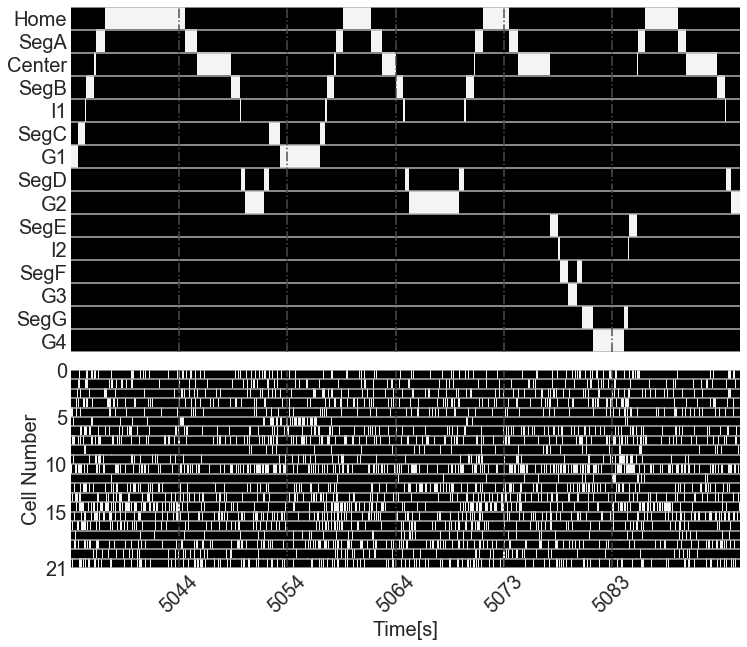

In [162]:
f,(a1,a2)=plt.subplots(2,1, figsize=(12,12))
t = PosDat['t']
a1.set_position([0.125, 0.4, 0.775, 0.4])
a1=plotBehWindow(t[window],PosDat['PosMat'].iloc[window].T,TMF.ZonesNames,a1)
a1.set_xticks([])

a2=plotBehWindow(t[window],cell_sp[:,window],np.arange(nCells).astype(str),a2)
a2.set_xlabel('Time[s]')
a2.set_ylabel('Cell Number')
a2.set_position([0.125, 0.15, 0.775, 0.23])
yt=np.linspace(0,nCells,5, endpoint=True).astype(int)
a2.set_yticks(yt)
a2.set_yticklabels(yt.astype(str))
for tick in a2.get_yticklabels():
    tick.set_rotation(0)

f.savefig('/Users/alexgonzalez/Google Drive/PostDoc/FloorMeeting/LocSpikesWindow.png',dpi=500,
          bbox_inches='tight',pad_inches=0.2)    

In [32]:
def PDeviance(y,mu):
    y = y+1e-10
    mu = mu+1e-10
    return 2*np.sum(y*np.log(y/mu)-(y-mu))

In [154]:
def plotFitComp(orig,fit,spks,time,a):    
    a.plot(time,orig,color='k',alpha=0.7)
    a.plot(time,fit,color='r',alpha=1)
    a.plot(time,spks,'k',alpha=0.5)
    a.set_ylabel('FR[sp/s]')
    a.set_xlabel('Time[s]')
    a.set_ylim([0,a.get_ylim()[1]])
    return a

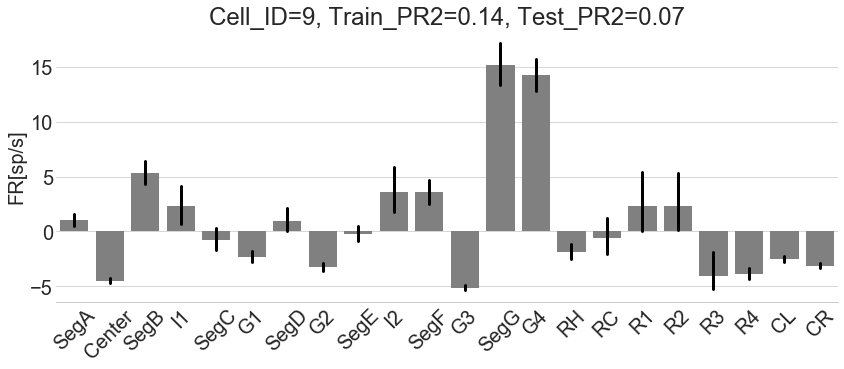

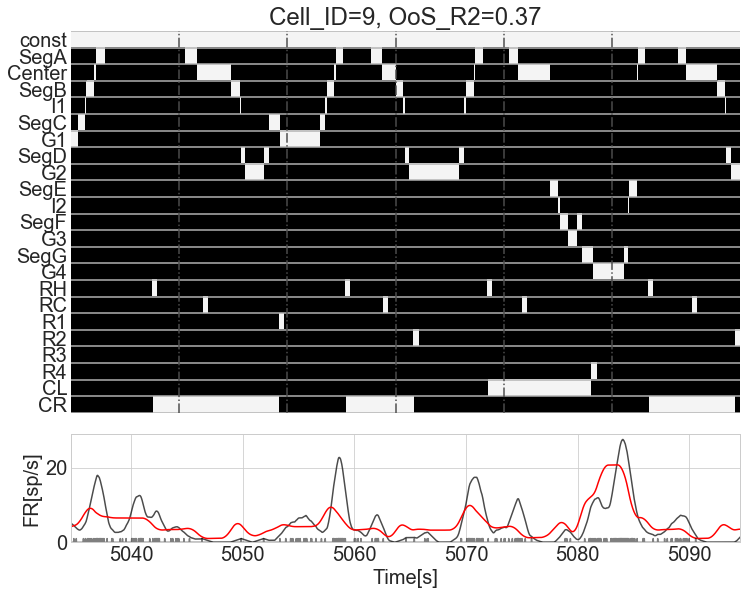

In [189]:
#selected_params = ['Home','SegA','Center','SegB','I1','SegC','G1','SegD',
#                   'G2','SegE','I2','SegF','G3','SegG','G4','RH','RC','R1','R2','R3','R4','CL','CR']
selected_params = ['SegA','Center','SegB','I1','SegC','G1','SegD',
                   'G2','SegE','I2','SegF','G3','SegG','G4','RH','RC','R1','R2','R3','R4','CL','CR']

pos_params = ['SegA','Center','SegB','I1','SegC','G1','SegD',
              'G2','SegE','I2','SegF','G3','SegG','G4']

reward_params = ['RH','RC','R1','R2','R3','R4']
cue_params = ['CL','CR']
dir_params = TMF.SegDirNames
goal_params = ['Home','Center','G1','G2','G3','G4']

FullMat=pd.concat([PosDat['PosMat'],PosDat['SegDirMat'],EventMat],axis=1)

#selected_params =goal_params+dir_params+reward_params+cue_params
selected_params =pos_params+reward_params+cue_params
#selected_params = pos_params+reward_params+cue_params+dir_params
M2 = sm.add_constant(FullMat[selected_params])

y=cell_sp[0,:]
xTrain, xTest, yTrain, yTest = train_test_split(M2,y, test_size = 0.5, random_state = 0,shuffle=False)
time_test = t[xTest.index]
window_test=np.where(np.logical_and(time_test>=minMark,time_test<(minMark+60)))[0]
    
glm_train_fits = {}
PR2_Train = np.zeros(nCells)
PR2_Test = np.zeros(nCells)
R2_Test = np.zeros(nCells)
# Turn interactive plotting off
pltshow = 1
if not pltshow:
    plt.ioff()
    
for cell in [9]:#np.arange(nCells):
    
    y=cell_sp[cell,:]
    if cell>0:
        _, _, yTrain, yTest = train_test_split(M2,y, test_size = 0.5, random_state = 0,shuffle=False)

    glm_train = sm.GLM(yTrain,xTrain,family = sm.families.Poisson())
    glm_null = sm.GLM(yTrain,xTrain['const'],family = sm.families.Poisson())
    glm_null_fit = glm_null.fit()
    glm_train_fits[cell] = glm_train.fit()

    PR2_Train[cell] = 1-glm_train_fits[cell].deviance/glm_null_fit.deviance
    muTest =glm_train_fits[cell].predict(xTest)
    TestDev = PDeviance(yTest,muTest)
    muNullTest = glm_null_fit.predict(xTest['const'])
    TestNullDev = PDeviance(yTest,muNullTest)
    PR2_Test[cell] = 1-TestDev/TestNullDev 
    
    f,a= plot_eFR(glm_train_fits[cell],step,selected_params)
    a.set_title('Cell_ID={0}, Train_PR2={1:0.2f}, Test_PR2={2:0.2f}'.format(cell,PR2_Train[cell],PR2_Test[cell]))
    f.savefig('/Users/alexgonzalez/Documents/Data/Li_T3g_062718_Results/GLM_Plots/GLM_Fits_Cell_{}.pdf'.format(cell),
              bbox_inches='tight',pad_inches=0.2)
    if not pltshow:
        plt.close(f)

    lfwin = np.round(1.0/step).astype(int)
    sm_yTest = signal.filtfilt(np.ones(lfwin)/lfwin,1,yTest)/step
    sm_muTest = signal.filtfilt(np.ones(lfwin)/lfwin,1,muTest.as_matrix())/step

    R2_Test[cell] = np.corrcoef(sm_yTest,sm_muTest)[0,1]**2
    
    
    f,(a1,a2)=plt.subplots(2,1, figsize=(12,10))
    a1.set_position([0.125, 0.38, 0.775, 0.53])
    a1=plotBehWindow(time_test[window_test],xTest.iloc[window_test].T,xTest.columns,a1)
    a1.set_xticks([])    
    a1.set_title('Cell_ID={0}, OoS_R2={1:0.2f}'.format(cell,R2_Test[cell]))

    a2.set_position([0.125, 0.2, 0.775, 0.15])
    a2=plotFitComp(sm_yTest[window_test],sm_muTest[window_test],
                   yTest[window_test]>0,time_test[window_test],a2 )
    a2.set_xlim(time_test[window_test][0],time_test[window_test][-1])
    f.savefig('/Users/alexgonzalez/Documents/Data/Li_T3g_062718_Results/GLM_Plots/GLM_FR_Plot_Cell_{}.png'.format(cell),
              dpi=500,bbox_inches='tight',pad_inches=0.2)  
    if not pltshow:
        plt.close(f)

In [342]:
def plot_eFR2(res,baseRate,step,selected_params):
    ci=(np.exp(res.conf_int())-baseRate)/step
    estimatedFRs = (np.exp(res.params)-baseRate)/step
    nParams=len(res.params)
    x=np.tile(np.arange(nParams),[2,1])
    #sns.barplot(x=np.arange(57),y=np.exp(res.params)-1,ci=np.exp(res.conf_int()-1),capsize=.2)
    
    f,a=plt.subplots(1,1, figsize=(14,5))
    ab=sns.barplot(x=np.arange(nParams),y=estimatedFRs,ax=a, 
                   facecolor=(0.5, 0.5, 0.5, 1))
    for p in np.arange(nParams):
        a.plot(x[:,p],ci.iloc[p],color='k',linewidth=3)
    a.set_ylabel('FR[sp/s]')
    a.set_xticklabels(selected_params)
    #a.grid()
    sns.set_style("whitegrid")
    sns.despine(left=True)
    for tick in a.get_xticklabels():
        tick.set_rotation(45)
    return f,a

In [491]:
def plot_params(params,ci,selected_params):

    nParams=len(params)
    x=np.tile(np.arange(nParams),[2,1])
    
    f,a=plt.subplots(1,1, figsize=(14,5))
    ab=sns.barplot(x=np.arange(nParams),y=params,ax=a, 
                   facecolor=(0.5, 0.5, 0.5, 1))
    for p in np.arange(nParams):
        a.plot(x[:,p],ci.iloc[p],color='k',linewidth=3)
        
    a.set_ylabel('PE [au]')
    a.set_xticklabels(selected_params)
    #a.grid()
    sns.set_style("whitegrid")
    sns.despine(left=True)
    for tick in a.get_xticklabels():
        tick.set_rotation(45)
    return f,a

In [500]:
model = 'Complete'

pos_params = ['Home','SegA','Center','SegB','I1','SegC','G1','SegD',
              'G2','SegE','I2','SegF','G3','SegG','G4']

reward_params = ['RH','RC','R1','R2','R3','R4']
cue_params = ['CL','CR']
dir_params = TMF.SegDirNames
goal_params = ['Home','Center','G1','G2','G3','G4']

sp = '/Users/alexgonzalez/Documents/Data/Li_T3g_062718_Results/GLM_Plots'

PlotDir = Path(sp,model)
PlotDir.mkdir(parents=True, exist_ok=True)

FullMat=pd.concat([PosDat['PosMat'],PosDat['SegDirMat'],EventMat],axis=1)

if model=='Complete':
    selected_params = pos_params + reward_params + cue_params
    M2 = sm.add_constant(FullMat[selected_params])
elif model=='Rewards':
    selected_params = reward_params
    M2 = sm.add_constant(FullMat[reward_params])
elif model=='Cues':
    selected_params = cue_params
    M2 = sm.add_constant(FullMat[reward_params])

y=cell_sp[0,:]
xTrain, xTest, yTrain, yTest = train_test_split(M2,y, test_size = 0.5, random_state = 0,shuffle=False)
time_test = t[xTest.index]
window_test=np.where(np.logical_and(time_test>=minMark,time_test<(minMark+60)))[0]
    
glm_train_fits = {}
PR2_Train = np.zeros(nCells)
PR2_Test = np.zeros(nCells)
R2_Test = np.zeros(nCells)
TrainBaseRate = np.zeros(nCells)
nParams = len(selected_params)
ZVals = pd.DataFrame(np.zeros((nCells,nParams)),columns=selected_params)
ParamsEst = pd.DataFrame(np.zeros((nCells,nParams)),columns=selected_params)
PVals = pd.DataFrame(np.zeros((nCells,nParams)),columns=selected_params)
plotFlag = 1
pltshow = 0
if not pltshow:
    plt.ioff()
    
for cell in np.arange(nCells):
    
    y=cell_sp[cell,:]
    if cell>0:
        _, _, yTrain, yTest = train_test_split(M2,y, test_size = 0.5, random_state = 0,shuffle=False)

    TrainBaseRate[cell] = np.mean(yTrain)
    
    # train model and firt to test set
    if model=='Complete':
        glm_train = sm.GLM(yTrain,xTrain.drop(['const'],axis=1),family = sm.families.Poisson())
        glm_train_fits[cell] = glm_train.fit()
        muTest =glm_train_fits[cell].predict(xTest.drop(['const'],axis=1))
    else:
        glm_train = sm.GLM(yTrain,xTrain,family = sm.families.Poisson())
        glm_train_fits[cell] = glm_train.fit()
        muTest =glm_train_fits[cell].predict(xTest)
        
    
    # get null / constant model fits
    glm_null = sm.GLM(yTrain,xTrain['const'],family = sm.families.Poisson())
    glm_null_fit = glm_null.fit()
    muNullTest = glm_null_fit.predict(xTest['const'])
   
    # get performance metrics
    PR2_Train[cell] = 1-glm_train_fits[cell].deviance/glm_null_fit.deviance
    TestDev = PDeviance(yTest,muTest)
    TestNullDev = PDeviance(yTest,muNullTest)
    PR2_Test[cell] = 1-TestDev/TestNullDev 
    
    # Store parameters
    ZVals.iloc[cell] = glm_train_fits[cell].tvalues
    ParamsEst.iloc[cell] = np.exp(glm_train_fits[cell].params)
    PVals.iloc[cell]=glm_train_fits[cell].pvalues

    # smooth binned spikes to obtain FRs
    lfwin = np.round(0.5/step).astype(int)
    sm_yTest = signal.filtfilt(np.ones(lfwin)/lfwin,1,yTest)/step
    sm_muTest = signal.filtfilt(np.ones(lfwin)/lfwin,1,muTest.as_matrix())/step

    R2_Test[cell] = np.corrcoef(sm_yTest,sm_muTest)[0,1]**2
    
    # plot results
    if plotFlag:
        f,a= plot_params(glm_train_fits[cell].params,glm_train_fits[cell].conf_int(),selected_params)
        a.set_title('Cell_ID={0}, Train_PR2={1:0.2f}, Test_PR2={2:0.2f}'.format(cell,PR2_Train[cell],PR2_Test[cell]))
        f.savefig(('{}/{}_GLM_Fits_RawParams_Cell_{}.pdf').format(sp,model,cell),bbox_inches='tight',pad_inches=0.2)
        if not pltshow:
            plt.close(f)
        
        f,a= plot_eFR2(glm_train_fits[cell],TrainBaseRate[cell],step,selected_params)
        a.set_title('Cell_ID={0}, Train_PR2={1:0.2f}, Test_PR2={2:0.2f}'.format(cell,PR2_Train[cell],PR2_Test[cell]))
        f.savefig(('{}/{}_GLM_Fits_eFRs_Cell_{}.pdf').format(sp,model,cell),bbox_inches='tight',pad_inches=0.2)
        if not pltshow:
            plt.close(f)
        
        f,(a1,a2)=plt.subplots(2,1, figsize=(12,10))
        a1.set_position([0.125, 0.38, 0.775, 0.53])
        a1=plotBehWindow(time_test[window_test],xTest.iloc[window_test].T,xTest.columns,a1)
        a1.set_xticks([])    
        a1.set_title('Cell_ID={0}, OoS_R2={1:0.2f}'.format(cell,R2_Test[cell]))

        a2.set_position([0.125, 0.2, 0.775, 0.15])
        a2=plotFitComp(sm_yTest[window_test],sm_muTest[window_test],
                       yTest[window_test]>0,time_test[window_test],a2 )
        a2.set_xlim(time_test[window_test][0],time_test[window_test][-1])
        f.savefig(('{}/{}_GLM_TestWindow_Cell_{}.png').format(sp,model,cell),dpi=500,bbox_inches='tight',pad_inches=0.2)

        if not pltshow:
            plt.close(f)

False

In [465]:
cell=14
y=cell_sp[cell,:]
_, _, yTrain, yTest = train_test_split(M2,y, test_size = 0.5, random_state = 0,shuffle=False)
glm_train = sm.GLM(yTrain,xTrain.drop(['const'],axis=1),family = sm.families.Poisson())
glm_null = sm.GLM(yTrain,xTrain['const'],family = sm.families.Poisson())
glm_null_fit = glm_null.fit()
glm_train_fits[cell] = glm_train.fit()


In [482]:
pa='Center'
np.mean(yTrain[xTrain[pa]])/step,ParamsEst[pa].loc[cell]/step


(41.20304540110843, 11.759082376029667)

In [350]:
np.exp(glm_train_fits[cell].params['Home'])

10.86690070351715

In [487]:
#X=(np.ParamsEst[reward_params]-np.tile(TrainBaseRate,[len(reward_params),1]).T>0)*(PVals[reward_params]*nParams*nCells<0.001)

X=np.log(ParamsEst[reward_params])
X

,RH,RC,R1,R2,R3,R4
0,-0.145369,-0.071356,-0.251186,0.084414,-0.155944,-0.161971
1,-0.273723,0.082610,-0.087069,0.063380,-0.075489,-0.143872
2,-0.238234,-0.028081,-0.192796,-0.140183,-0.221809,-0.211014
3,-0.349746,-0.303213,-0.316235,0.003384,-0.144198,-0.153547
4,-0.086459,0.024052,-0.012363,0.104985,-0.101691,-0.035850
5,-0.131548,-2.341411,1.003434,-3.139073,0.135233,-0.711476
6,-0.405218,-0.342229,-0.127765,-0.294339,-0.393689,0.105613
7,-0.213623,-0.141371,-0.020254,-0.424119,-0.227082,-0.050577
8,-1.464796,-0.297631,-1.468727,0.400991,-1.033215,-0.645258
9,-0.340246,-0.100228,0.303637,0.307330,-0.954118,-0.892103


In [451]:
ZVals[reward_params].loc[14]

RH   -1.858327
RC   -7.645602
R1   -2.643148
R2   -2.817244
R3   -5.176846
R4   -3.649426
Name: 14, dtype: float64

Home      21.654222
SegA       9.236695
Center    -3.598920
SegB       8.897570
I1         5.604045
SegC       2.538475
G1        -5.041505
SegD       6.656821
G2        -9.029404
SegE       1.538201
I2         6.617961
SegF       1.846251
G3        -8.476314
SegG       8.796445
G4        -0.467933
RH        32.189901
RC        14.020176
R1        20.154315
R2        18.046659
R3         6.178264
R4        20.478647
CL        15.781963
CR        12.592349
dtype: float64

In [357]:
(ParamsEst[['CL','CR']].as_matrix()>0)*(PVals[['CL','CR']]*nParams*nCells<0.001).as_matrix()

array([[False, False],
       [False, False],
       [False, False],
       [ True,  True],
       [False, False],
       [ True,  True],
       [False, False],
       [False, False],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False, False],
       [False,  True],
       [ True,  True],
       [ True,  True],
       [False, False],
       [ True, False],
       [False, False],
       [False, False],
       [ True,  True],
       [False, False]])

In [392]:
pa = 'Center'
((ParamsEst[pa]-TrainBaseRate)>0)*(PVals[pa]<0.001)*R2_Test>0.3

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15     True
16    False
17    False
18    False
19     True
20    False
Name: Center, dtype: bool

In [409]:
np.sqrt(R2_Test)[R2_Test>0.5]

array([0.79096877])

In [414]:
200

4.315789473684211

In [936]:
#selected_params = ['Home','SegA','Center','SegB','I1','SegC','G1','SegD',
#                   'G2','SegE','I2','SegF','G3','SegG','G4','RH','RC','R1','R2','R3','R4','CL','CR']
selected_params = ['SegA','Center','SegB','I1','SegC','G1','SegD',
                   'G2','SegE','I2','SegF','G3','SegG','G4','RH','RC','R1','R2','R3','R4','CL','CR']

pos_params = ['SegA','Center','SegB','I1','SegC','G1','SegD',
              'G2','SegE','I2','SegF','G3','SegG','G4']

reward_params = ['RH','RC','R1','R2','R3','R4']
cue_params = ['CL','CR']
dir_params = TMF.SegDirNames
goal_params = ['Home','Center','G1','G2','G3','G4']

FullMat=pd.concat([PosDat['PosMat'],PosDat['SegDirMat'],EventMat],axis=1)

#selected_params =goal_params+dir_params+reward_params+cue_params
selected_params =pos_params+reward_params+cue_params
#selected_params = pos_params+reward_params+cue_params+dir_params
M2 = sm.add_constant(FullMat[selected_params])

y=cell_sp[0,:]
xTrain, xTest, yTrain, yTest = train_test_split(M2,y, test_size = 0.5, random_state = 0,shuffle=False)

In [185]:
RewardMat = EventMat[reward_params]

detect_params = ['DH','DC','D1','D2','D3','D4']
DetecMat = EventMat[detect_params] 
reLength = 1/step # one second
deLength = 1.5*1/step # two secs

for r in reward_params:
    RewardMat[r] = (signal.lfilter(np.arange(reLength),1,RewardMat[r])>0).astype(int)
    
for d in detect_params:
    DetecMat[d] = (signal.lfilter(np.arange(deLength),1,DetecMat[d])>0).astype(int)
    
cnt = 0


In [187]:
ReDeMat=pd.concat([DetecMat,RewardMat],axis=1)
selected_params = detect_params+reward_params
M2 = sm.add_constant(ReDeMat)

y=cell_sp[0,:]
xTrain, xTest, yTrain, yTest = train_test_split(M2,y, test_size = 0.5, random_state = 0,shuffle=False)
time_test = t[xTest.index]
window_test=np.where(np.logical_and(time_test>=minMark,time_test<(minMark+60)))[0]
    
glm_train_fits = {}
PR2_Train = np.zeros(nCells)
PR2_Test = np.zeros(nCells)
R2_Test = np.zeros(nCells)
# Turn interactive plotting off
plt.ioff()
for cell in np.arange(nCells):
    
    if cell>0:
        y=cell_sp[cell,:]
        _, _, yTrain, yTest = train_test_split(M2,y, test_size = 0.5, random_state = 0,shuffle=False)

    glm_train = sm.GLM(yTrain,xTrain,family = sm.families.Poisson())
    glm_null = sm.GLM(yTrain,xTrain['const'],family = sm.families.Poisson())
    glm_null_fit = glm_null.fit()
    glm_train_fits[cell] = glm_train.fit()

    PR2_Train[cell] = 1-glm_train_fits[cell].deviance/glm_null_fit.deviance
    muTest =glm_train_fits[cell].predict(xTest)
    TestDev = PDeviance(yTest,muTest)
    muNullTest = glm_null_fit.predict(xTest['const'])
    TestNullDev = PDeviance(yTest,muNullTest)
    PR2_Test[cell] = 1-TestDev/TestNullDev 
    
    f,a= plot_eFR(glm_train_fits[cell],step,selected_params)
    a.set_title('Cell_ID={0}, Train_PR2={1:0.2f}, Test_PR2={2:0.2f}'.format(cell,PR2_Train[cell],PR2_Test[cell]))
    f.savefig('/Users/alexgonzalez/Documents/Data/Li_T3g_062718_Results/GLM_Plots/GLM_FitsReDe_Cell_{}.pdf'.format(cell),
              bbox_inches='tight',pad_inches=0.2)    
    plt.close(f)

    lfwin = np.round(1.0/step).astype(int)
    sm_yTest = signal.filtfilt(np.ones(lfwin)/lfwin,1,yTest)/step
    sm_muTest = signal.filtfilt(np.ones(lfwin)/lfwin,1,muTest.as_matrix())/step

    R2_Test[cell] = np.corrcoef(sm_yTest,sm_muTest)[0,1]**2
     
    f,(a1,a2)=plt.subplots(2,1, figsize=(12,10))
    a1.set_position([0.125, 0.38, 0.775, 0.53])
    a1=plotBehWindow(time_test[window_test],xTest.iloc[window_test].T,xTest.columns,a1)
    for tick in a1.get_yticklabels():
        tick.set_rotation(0)
    
    a1.set_xticks([])    
    a1.set_title('Cell_ID={0}, OoS_R2={1:0.2f}'.format(cell,R2_Test[cell]))

    a2.set_position([0.125, 0.2, 0.775, 0.15])
    a2=plotFitComp(sm_yTest[window_test],sm_muTest[window_test],
                   yTest[window_test]>0,time_test[window_test],a2 )
    a2.set_xlim(time_test[window_test][0],time_test[window_test][-1])
    f.savefig('/Users/alexgonzalez/Documents/Data/Li_T3g_062718_Results/GLM_Plots/GLM_FR_ReDe_Plot_Cell_{}.png'.format(cell),
              dpi=500,bbox_inches='tight',pad_inches=0.2)  
    plt.close(f)
plt.show()

In [182]:
M2

,const,DH,DC,D1,D2,D3,D4,RH,RC,R1,R2,R3,R4
0,1.0,False,False,False,False,False,False,False,False,False,False,False,False
1,1.0,False,False,False,False,False,False,False,False,False,False,False,False
2,1.0,False,False,False,False,False,False,False,False,False,False,False,False
3,1.0,False,False,False,False,False,False,False,False,False,False,False,False
4,1.0,False,False,False,False,False,False,False,False,False,False,False,False
5,1.0,False,False,False,False,False,False,False,False,False,False,False,False
6,1.0,False,False,False,False,False,False,False,False,False,False,False,False
7,1.0,False,False,False,False,False,False,False,False,False,False,False,False
8,1.0,False,False,False,False,False,False,False,False,False,False,False,False
9,1.0,False,False,False,False,False,False,False,False,False,False,False,False
